In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.prepare_data import prepare_mfcc, create_audio_path_and_text, read_phonemes, prepare_input_data, phonemes_to_ids
from utils.helpers import check_cuda, model_wer, create_dataloader, ModelSaver
import random


In [2]:
mfcc_to_extract = 40
device = check_cuda()

# dev
# train-100
# train-360
# train-500
audio_to_train = "train-360"

CUDA is available. Using GPU device: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
# create_audio_path_and_text("audio/dev","data/text_and_path/dev.txt")
# create_audio_path_and_text("audio/test","data/text_and_path/test.txt")
# create_audio_path_and_text("audio/dev-other","data/text_and_path/dev-other.txt")
# create_audio_path_and_text("audio/test-other","data/text_and_path/test-other.txt")
# create_audio_path_and_text("audio/train-100","data/text_and_path/train-100.txt")
#create_audio_path_and_text("audio/train-360","data/text_and_path/train-360.txt")
# create_audio_path_and_text("audio/train-500","data/text_and_path/train-500.txt")

In [5]:
# prepare_mfcc(audio_paths_file="data/text_and_path/dev.txt", output=f"data/mfcc/dev")
# prepare_mfcc(audio_paths_file="data/text_and_path/test.txt", output=f"data/mfcc/test")
# prepare_mfcc(audio_paths_file="data/text_and_path/dev-other.txt", output=f"data/mfcc/dev-other")
# prepare_mfcc(audio_paths_file="data/text_and_path/test-other.txt", output=f"data/mfcc/test-other")
# prepare_mfcc(audio_paths_file="data/text_and_path/train-100.txt", output=f"data/mfcc/train-100")
# prepare_mfcc(audio_paths_file="data/text_and_path/train-360.txt", output=f"data/mfcc/train-360")
# prepare_mfcc(audio_paths_file="data/text_and_path/train-500.txt", output=f"data/mfcc/train-500")

In [6]:
phonemes = read_phonemes("utils/phonemes.txt")
phoneme2id,id2phoneme = phonemes_to_ids(phonemes)

train_mfcc_files, train_phoneme_targets = prepare_input_data(f"data/mfcc/{audio_to_train}")
test_mfcc_files, test_phoneme_targets = prepare_input_data(f"data/mfcc/test")
test_other_mfcc_files, test_other_phoneme_targets = prepare_input_data(f"data/mfcc/test-other")

train_dataloader =  create_dataloader(train_mfcc_files, train_phoneme_targets, phoneme2id, batch_size=16,shuffle = True,num_work=4)
test_dataloader = create_dataloader(test_mfcc_files, test_phoneme_targets, phoneme2id, batch_size=16)
test_other_dataloader = create_dataloader(test_other_mfcc_files, test_other_phoneme_targets, phoneme2id, batch_size=16)

In [7]:
# навчання дітей читати, замість оцінки вимови,оцінювати складність речень, видавати по рівнях,гейміфікація
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [ ]:
class ResidualTDNNBlock(nn.Module):
    def __init__(self, channels, kernel_size, dilation=1, dropout=None,bypass_scale = 0.5):
        super().__init__()
        self.tdnn1 = TDNNBlock(channels, channels, kernel_size, dilation, dropout)
        self.tdnn2 = TDNNBlock(channels, channels, kernel_size, dilation, dropout)
        self.bypass_scale = bypass_scale

    def forward(self, x):
        residual = x
        out = self.tdnn1(x)
        out = self.tdnn2(out)
        return out + residual * self.bypass_scale

class TDNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, dropout=None, activation = True):
        super().__init__()
        padding = dilation * (kernel_size // 2)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                            dilation=dilation, padding=padding)
        self.ln = nn.LayerNorm(out_channels)
        self.relu = nn.ReLU() if activation is True else nn.Identity()# wer 17
        self.dropout = nn.Dropout1d(dropout) if dropout is not None else nn.Identity()

    def forward(self, x):  # x: [B, C_in, T]
        out = self.conv(x)           # [B, C_out, T]
        out = out.transpose(1,2)
        out = self.ln(out)
        out = out.transpose(1,2)
        out = self.relu(out)
        out = self.dropout(out)
        return out

class TDNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TDNN, self).__init__()
        self.tdnn1 = TDNNBlock(input_dim, 400, kernel_size=7,dilation=1)
        self.tdnn2 = TDNNBlock(400, 400, kernel_size=5, dilation=2,dropout=0.2)
        self.tdnn3 = TDNNBlock(400, 400, kernel_size=5, dilation=3,dropout=0.3)
        self.res1 = ResidualTDNNBlock(400, kernel_size=3, dilation=2)
        self.res2 = ResidualTDNNBlock(400, kernel_size=3,dilation=1)
        self.res3 = ResidualTDNNBlock(400, kernel_size=3,dilation=1)
        self.tdnn4 = TDNNBlock(400, 300, kernel_size=1,dropout=0.3)
        self.tdnn5 = TDNNBlock(300, 300, kernel_size=1,dropout=0.4)
        self.tdnn6 = TDNNBlock(300, output_dim, kernel_size=1, activation = False)
 
    def forward(self, x):  # x: [B, T, F]
        x = x.transpose(1, 2)  # [B, F, T]
        x = self.tdnn1(x)
        x = self.tdnn2(x)
        x = self.tdnn3(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.tdnn4(x)
        x = self.tdnn5(x)
        x = self.tdnn6(x)
        x = x.transpose(1, 2)  # [B, T, F]
        return F.log_softmax(x, dim=-1)

In [10]:
saver = ModelSaver()
num_epoch = 100

In [11]:
def train_model(model,checkpoint_path = None):

    #optimizer = torch.optim.AdamW(model.parameters(),weight_decay=1e-6)
    optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3, weight_decay=1e-2)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    ctc_loss = nn.CTCLoss(blank=0)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    train_losses = []
    val_losses = []
    wers = []
    best_wer = float('inf')
    start_epoch = 1

    if checkpoint_path is not None:
        point_model,point_optimizer,point_scheduler,point_epoch,point_train_loss,point_val_loss,point_wers = saver.load_checkpoint(model=model,scheduler=scheduler,optimizer=optimizer,path = checkpoint_path)
        
        model = point_model
        optimizer = point_optimizer
        scheduler = point_scheduler
        start_epoch = point_epoch
        train_losses = point_train_loss
        val_losses = point_val_loss
        wers = point_wers

        for curr_epoch, (train_loss, val_loss, wer) in enumerate(zip(train_losses, val_losses, wers)):
            val = f"Epoch:{curr_epoch+1} Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Wer: {wer:.4f}"
            saver.log(f"{timestamp}/model_log.txt", val)

        print(f"Continue learning from epoch: {point_epoch}")
        

    try:
        saver.clear_backup()
        saver.save_structure(model, timestamp)
        for epoch in range(start_epoch, num_epoch + 1):
            model.train()
            total_loss = 0

            # Train losses
            for mfccs_padded, targets_concat, mfcc_lengths, target_lengths in train_dataloader:
                mfccs_padded = mfccs_padded.to(device)  # send B,T,F
                targets_concat = targets_concat.to(device)
                mfcc_lengths = mfcc_lengths.to(device)
                target_lengths = target_lengths.to(device)

                optimizer.zero_grad()
                outputs = model(mfccs_padded)
                log_probs = outputs.transpose(0, 1)
                loss_train = ctc_loss(log_probs, targets_concat, mfcc_lengths, target_lengths)
                loss_train.backward()
                optimizer.step()
                total_loss += loss_train.item()

            train_losses.append(total_loss)

            # Val losses
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for mfccs_padded, targets_concat, mfcc_lengths, target_lengths in test_dataloader:
                    mfccs_padded = mfccs_padded.to(device)  # send B,T,F
                    targets_concat = targets_concat.to(device)
                    mfcc_lengths = mfcc_lengths.to(device)
                    target_lengths = target_lengths.to(device)
                    outputs = model(mfccs_padded)
                    log_probs = outputs.transpose(0, 1)
                    loss_test = ctc_loss(log_probs, targets_concat, mfcc_lengths, target_lengths)
                    val_loss += loss_test.item()

            val_losses.append(val_loss)
            scheduler.step(val_loss)

            # Word Error Rate
            wer = model_wer(model, device, test_dataloader, id2phoneme)
            wers.append(wer)
            # Save best model
            if wer < best_wer:
                best_wer = wer
                wer_norm = int(round(wer * 100))
                saver.save_best_checkpoint(model = model,optimizer=optimizer,scheduler=scheduler,epoch=epoch,
                                        train_losses=train_losses,val_losses=val_losses,wers=wers,
                                        name = f"{timestamp}/point_wer-{wer_norm}_ep-{epoch}.pth")

            val = f"Epoch:{epoch} Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, Wer: {wer:.4f}"
            saver.log(f"{timestamp}/model_log.txt", val)
            if epoch % 5 == 0 or epoch == 1 or epoch == num_epoch:
                print(val)

            # backup
            if epoch % 2 == 0:
                wer_norm = int(round(wer * 100))
                saver.save_checkpoint(model = model,optimizer=optimizer,scheduler=scheduler,epoch=epoch,
                                    train_losses=train_losses,val_losses=val_losses,wers=wers,
                                    path = f"backup/{timestamp}_point_wer-{wer_norm}_ep-{epoch}")

    except KeyboardInterrupt:
        print(f"Stopped on epoch №{epoch}")

    finally:
        # Save final model
        saver.save_checkpoint(model = model,scheduler=scheduler,optimizer=optimizer,epoch=epoch,
                              train_losses=train_losses,val_losses=val_losses,wers=wers,
                              path = f"models/{timestamp}/point_final_ep-{epoch}")
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        axs[0].plot(train_losses, label='Train Loss')
        axs[0].plot(val_losses, label='Val Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].set_title('CTC Loss over Epochs')
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(wers, label='Val WER', color='orange')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('WER')
        axs[1].set_title('WER over Epochs')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.savefig(f"models/{timestamp}/model_{audio_to_train}_{timestamp}_ep-{epoch}.png")
        plt.show()

Continue learning from epoch: 51
Epoch:55 Loss: 2019.7260, Val Loss: 81.1665, Wer: 0.1200
Epoch:60 Loss: 1968.7452, Val Loss: 81.3565, Wer: 0.1194
Epoch:65 Loss: 1938.0727, Val Loss: 81.1270, Wer: 0.1197
Stopped on epoch №69


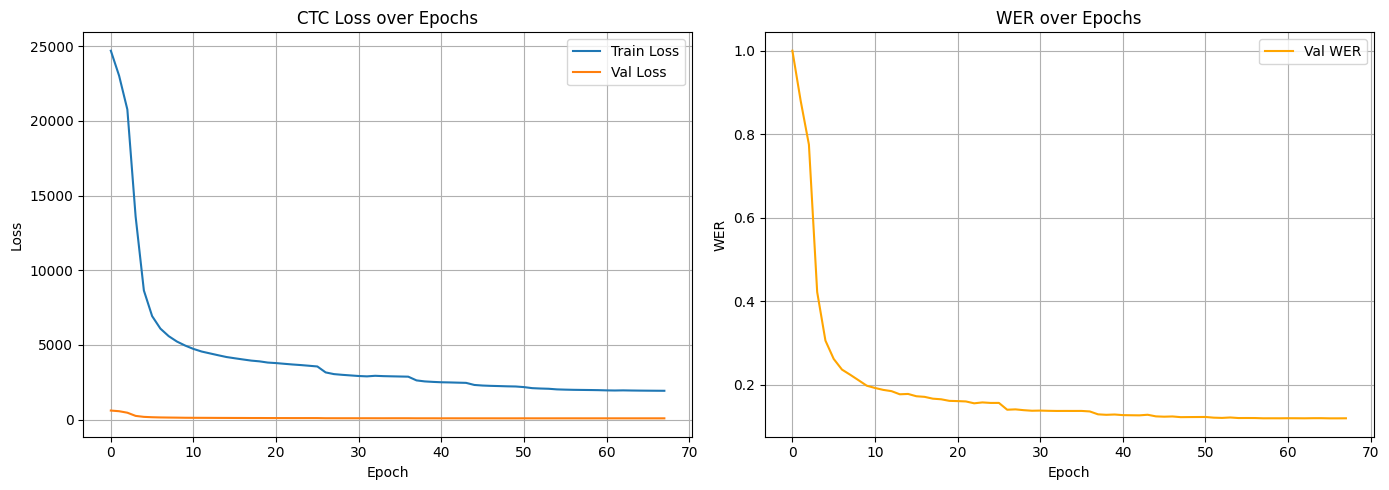

In [12]:
model = TDNN(mfcc_to_extract, len(phoneme2id)).to(device)
#train_model(model)
train_model(model = model,checkpoint_path= "models/2025-07-21_23-30/point_final_ep-51")

In [13]:
# easier
model_wer(model,device,test_dataloader,id2phoneme,show = True)

Real vs Predicted (first 5):

1. Real: HH IY1 HH OW1 P T DH EH1 R W UH1 D B IY1 S T UW1 F R ER0 D IH1 N ER0 T ER1 N AH0 P S AH0 N D K EH1 R AH0 T S AH0 N D B R UW1 Z D P AH0 T EY1 T OW0 Z AH0 N D F AE1 T M AH1 T AH0 N P IY1 S IH0 Z T UW1 B IY1 L EY1 D AH0 L D AW1 T IH1 N TH IH1 K P EH1 P ER0 D F L AW1 R F AE1 T AH0 N D S AO1 S
   Pred: HH IY1 HH OW1 P T DH EH1 R W UH1 D B IY1 S T UW1 F R ER0 D IH1 N ER0 T ER1 N IH1 P S AH0 N D K EH1 R AH0 T S EH1 N D B R UW1 Z D P AH0 T EY1 T OW2 Z AH0 N D F AE1 T M AH1 T AH0 N P IY1 S IH0 S T UW1 B IY1 L EY1 T AH0 L D AW1 T IH1 N DH IY0 TH IH1 K P EH1 P ER0 D F L AW1 ER0 F AE1 T AH0 N D S AO1 S

2. Real: S T AH1 F IH1 T IH1 N T UW0 Y UW1 HH IH1 Z B EH1 L IY0 K AW1 N S AH0 L D IH0 M
   Pred: S T AH1 F AH0 D AH0 N T UW0 Y UW1 HH IH1 Z B EH1 L IY0 K AW1 N S AH0 L D IH0 M

3. Real: AE1 F T ER0 ER1 L IY0 N AY1 T F AO2 L DH IY0 Y EH1 L OW0 L AE1 M P S W UH1 D L AY1 T AH1 P HH IY1 R AH0 N D DH EH1 R DH IY0 S K W AA1 L AH0 D K W AO1 R T ER0 AH1 V DH IY0 B R A

0.11933249869257223

In [14]:
# harder
model_wer(model,device,test_other_dataloader,id2phoneme,show = True)

Real vs Predicted (first 5):

1. Real: DH EH1 R Z AY1 ER0 N DH EY1 S EY1 IH1 N AO1 L AW1 R B L AH1 D AH0 N D EY1 G R EY1 N ER0 T UW1 P ER0 HH AE1 P S IH1 Z G UH1 D B AH1 T HH IH1 Z HH IY1 M EY1 K S M IY1 HH AA1 R SH L IY0 F IY1 L HH AH0 Z G AA1 T EY1 L IH1 T AH0 L T UW1 M AH1 CH AH1 V S T IY1 L AE2 N AH0 N
   Pred: DH EH1 T HH IH1 Z AY1 N D DH EY1 S EY1 IH1 N AO1 L D AA1 B L AH1 D AH0 N D EY1 G R EY1 N ER0 T UW1 P AE1 P S HH IH1 Z G UH1 D B AH1 T HH IH1 Z HH IY1 M EY1 K S M IY1 HH AA1 SH L IY0 D F IY1 L HH AH0 Z G AA1 T AH0 M IH1 T AH0 L T UW1 M AH1 CH AH1 V S T EY1 L AY1 N AO1 N

2. Real: M AA1 R G R IH0 T S EH1 D M IH1 S T ER0 HH EY1 L EH1 Z HH IY1 R IY0 T ER1 N D F R AH1 M SH OW1 IH0 NG HH IH1 Z G EH1 S T D AW1 N S T EH1 R Z AY1 K UH1 D N AA1 T HH EH1 L P W AA1 CH IH0 NG Y UH1 R F EY1 S W IH1 TH S AH1 M AE0 NG Z AY1 AH0 T IY0 W IH1 N M IH1 S T ER0 TH AO1 R N T AH0 N M EY1 D HH IH1 Z K AH0 N F EH1 SH AH0 N AH1 V HH AE1 V IH0 NG B IH1 N EY1 SH AA1 P B OY1
   Pred: M AA1 G ER0 IH0 D S 

0.29840201757670537

In [ ]:
# training data
model_wer(model,device,train_dataloader,id2phoneme,show = True)

In [ ]:
# import numpy as np
# mode = "dev"
# file_num = 14

# test_files = []

# with open(f"data/mfcc/{mode}/trans.txt", "r", encoding="utf-8") as f:
#     for line in f:
#         parts = line.strip().split('\t')  
#         test_files.append(parts)

# mfcc = np.load(f"data/mfcc/{mode}/{test_files[file_num][0]}")
# mfcc = mfcc.T  # [time, n_mfcc]

# mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).to(device)  # [1, time, n_mfcc]
# mfcc_tensor = mfcc_tensor.transpose(1, 2)  # [1, n_mfcc, time]


# with torch.no_grad():
#     output = model(mfcc_tensor)  # [1, time, classes]
#     pred = torch.argmax(output, dim=-1)[0]  # [time]

# def ctc_decode(pred, blank=0):
#     decoded = []
#     prev = None
#     for p in pred.cpu().numpy():
#         if p != blank and p != prev:
#             decoded.append(p)
#         prev = p
#     return decoded

# pred_ids = ctc_decode(pred)
# decoded_phonemes = [id2phoneme[i] for i in pred_ids]

# val = test_files[file_num][1]
# val = val.replace("'", "")
# val = val.replace(",", "")
# val = val[1:-1]

# print(f"filename {test_files[file_num][0]}")
# print(f" Expected: {val}")
# print("Predicted:", " ".join(decoded_phonemes))